This is an extra notebook to help me understand the construct_heterogeneous_graph_jihwan.py and construct_heterogeneous_graph_PyG_jihwan.py scripts, by visualizing how the graph gets constructed. In the first script the graph is constructed using the ppi (reactome3.txt) and the gene-cell dependency score (CRISPRGeneEffect.csv). The second script builds further on that graph by adding cell and gene features.

In [20]:
import torch
import sys
#sys.path.append('/Users/jovanafilipovic/Downloads/MSc Bioinformatics/Year 2/Thesis/Python_scripts')
from NetworkAnalysis.MultiGraph import MultiGraph
from NetworkAnalysis.UndirectedInteractionNetwork import UndirectedInteractionNetwork
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os
import xlrd

In [21]:
BASE_PATH = "./Data/"
cancer_type = "Neuroblastoma"
train_ratio = 0.8
ppi = "Reactome"
remove_rpl = "_noRPL" #remove ribosomal proteins
remove_commonE = ""  #this will not be removed
useSTD = "STD"
crispr_threshold_pos = -1.5
ppi_train_ratio = 0.8

In [22]:

# Read in all relevant DepMap data
ccles_ori = pd.read_csv(BASE_PATH+"Depmap/Model.csv", index_col=0)
#ccles = ccles_ori.loc[ccles_ori.PatientID.drop_duplicates().index]
ccles = ccles_ori
ccles['OncotreePrimaryDisease'].value_counts()
#list(ccles['OncotreePrimaryDisease'].value_counts())
print(len(ccles))

1959


In [23]:
path = BASE_PATH+'Depmap/CRISPRGeneEffect.csv'
crispr_effect = pd.read_csv(path, header=0, index_col=0)
crispr_effect.columns = [i.split(' ')[0] for i in crispr_effect.columns]
crispr_effect.head()
print(len(crispr_effect))


1150


In [24]:
# Read in PPI and construct prior node embeddings
# Ndex2 pcnet 
if ppi == 'PCNet':
    ppi_obj = UndirectedInteractionNetwork.from_ndex(ndex_id='c3554b4e-8c81-11ed-a157-005056ae23aa', keeplargestcomponent=False,
                                                    attributes_for_names='v', node_type=int)
else:
    ppi_ = pd.read_csv(BASE_PATH+'reactome3.txt', header=0, sep='\t')
    ppi_obj = UndirectedInteractionNetwork(ppi_, keeplargestcomponent=False) #You are keeping all components, not just the largest connected one.
    
ppi_obj.set_node_types(node_types={i: "gene" for i in ppi_obj.node_names}) #set node type to gene for each node

degreedf = ppi_obj.getDegreeDF(set_index=True) #dataframe with degree of each node
degreedf.loc[['BRIP1', 'RRM2','LCE2C','MYCN']]
print(degreedf)

print(len(ppi_obj  ))

Continuing with Gene1 and Gene2 as columns for the nodes
14034 Nodes and 278974 interactions
          Gene  Count
EP300    EP300   1058
RPS27A  RPS27A   1004
UBA52    UBA52    962
GNB1      GNB1    945
PRKACA  PRKACA    929
...        ...    ...
PNPLA5  PNPLA5      1
POC5      POC5      1
PODXL    PODXL      1
TSPY2    TSPY2      1
PMM1      PMM1      1

[14034 rows x 2 columns]
14034


In [25]:
ppi_obj

        Gene_A   Gene_B
0         A1CF  APOBEC1
1         A1CF    CELF2
2         A1CF    EP300
3         A1CF    RBM47
4          A2M    APOA1
...        ...      ...
278969    ZW10   ZWILCH
278970    ZW10    ZWINT
278971  ZWILCH    ZWINT
278972    ZXDA     ZXDB
278973    ZXDA     ZXDC

[278974 rows x 2 columns]

In [26]:
# Select genes for which all features are avaialble and are situated in the network
focus_genes = sorted(list(set(ppi_obj.node_names) & set(crispr_effect.columns))) #select genes that are in both ppi and crispr
#assert len(focus_genes) == ppi_obj.N_nodes,"Error node mismatch" #12951 / 13953

#focus_genes2int = {k:i for i, k in enumerate(focus_genes)}
#focus_int2gene = {v:k for k, v in focus_genes2int.items()}

focus_cls = sorted(list(set(ccles.index) & set(crispr_effect.index))) #select cell lines that are in both ccles and crispr
ccles = ccles.loc[focus_cls, :] # filter only focus cell line
crispr_effect = crispr_effect.loc[focus_cls, focus_genes] # filter only focus cell line & gene

print(len(crispr_effect))
print(len(focus_genes))
print(len(focus_cls))

1150
13330
1150


In [27]:
# Group cell lines by disease and aggregate into a list
dis_groups = ccles.groupby("OncotreePrimaryDisease").apply(lambda df: list(df.index)).to_frame(name="cells")
dis_groups["length"] = dis_groups["cells"].apply(len)

if cancer_type:
    crispr_neurobl = crispr_effect.loc[dis_groups.loc[cancer_type, "cells"]]

print(dis_groups)
print(len(crispr_neurobl))

                                                                                                cells  \
OncotreePrimaryDisease                                                                                  
Acute Myeloid Leukemia                              [ACH-000004, ACH-000005, ACH-000045, ACH-00011...   
Adenosquamous Carcinoma of the Pancreas                                      [ACH-000108, ACH-000685]   
Adrenocortical Carcinoma                                                                 [ACH-001401]   
Ampullary Carcinoma                                  [ACH-000182, ACH-000377, ACH-001862, ACH-002023]   
Anaplastic Thyroid Cancer                           [ACH-000174, ACH-000191, ACH-001306, ACH-00130...   
...                                                                                               ...   
T-Lymphoblastic Leukemia/Lymphoma                   [ACH-000206, ACH-000937, ACH-000953, ACH-00099...   
Undifferentiated Pleomorphic Sarcoma/Malignant ...     

/var/folders/ds/76n_grr91zn97zn1yl541y5c0000gn/T/ipykernel_54938/2797604355.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dis_groups = ccles.groupby("OncotreePrimaryDisease").apply(lambda df: list(df.index)).to_frame(name="cells")


In [28]:
dis_groups_d = ccles.groupby('OncotreePrimaryDisease').groups
dis_groups = pd.DataFrame.from_dict(dis_groups_d, orient='index').map(lambda x: '' if x is None else x) 
dis_groups = dis_groups.apply(lambda x: ','.join(x), axis=1).apply(lambda x: [i for i in x.split(',') if i]).to_frame(name='cells') 
dis_groups['length'] = dis_groups["cells"].apply(lambda x: len(x)) 
# disgroups with 2 columns: cells (list of cellines associated with disease), length (len(cells))
# OncotreePrimaryDisease is used as index

dis_groups

,cells,length
Acute Myeloid Leukemia,"[ACH-000004, ACH-000005, ACH-000045, ACH-00011...",26
Adenosquamous Carcinoma of the Pancreas,"[ACH-000108, ACH-000685]",2
Adrenocortical Carcinoma,[ACH-001401],1
Ampullary Carcinoma,"[ACH-000182, ACH-000377, ACH-001862, ACH-002023]",4
Anaplastic Thyroid Cancer,"[ACH-000174, ACH-000191, ACH-001306, ACH-00130...",7
...,...,...
T-Lymphoblastic Leukemia/Lymphoma,"[ACH-000206, ACH-000937, ACH-000953, ACH-00099...",5
Undifferentiated Pleomorphic Sarcoma/Malignant Fibrous Histiocytoma/High-Grade Spindle Cell Sarcoma,"[ACH-000835, ACH-001164]",2
Urethral Cancer,"[ACH-000973, ACH-001408]",2
Uterine Sarcoma/Mesenchymal,"[ACH-000913, ACH-000939, ACH-001655]",3


In [29]:
common_essentials_control_df = pd.read_csv(BASE_PATH+f"Depmap/AchillesCommonEssentialControls.csv")
common_essentials_control = list([i[0].split(' ')[0] for i in common_essentials_control_df.values]) #extract the gene name

print(common_essentials_control_df)

#defining non-interesting genes (e.g. Ribosomal proteins = RPL)
rpls = set([i for i in common_essentials_control if 'RPL' in i]) | set([i for i in ppi_obj.node_names if 'RPL' in i]) | set([i for i in crispr_neurobl.columns if 'RPL' in i]) # remove non interesting genes
# ppi_obj.getDegreeDF(set_index=True).loc[set(rpls) & set(ppi_obj.node_names)]

std_threshold = 0.2
std_dependencies = list(crispr_neurobl.columns[crispr_neurobl.std() > std_threshold])

if remove_commonE:
    print("Removing common essentials")
    if remove_rpl: #remove common essentials and ribosomal proteins
        final_pos = list(set(std_dependencies) - set(common_essentials_control) - rpls)
    else:
        final_pos = list(set(std_dependencies) - set(common_essentials_control))
else:
    if remove_rpl: #remove ribosomal proteins
        final_pos = list(set(std_dependencies) - rpls)
    else:
        final_pos = std_dependencies

print(len(final_pos))


                  Gene
0            AAMP (14)
1           AARS1 (16)
2     AASDHPPT (60496)
3           ABCB7 (22)
4         ABCE1 (6059)
...                ...
1242    ZNF407 (55628)
1243    ZNF574 (64763)
1244    ZNF622 (90441)
1245    ZNHIT6 (54680)
1246      ZZZ3 (26009)

[1247 rows x 1 columns]
2296


In [30]:
with open(BASE_PATH+f"multigraphs/{cancer_type.replace(' ', '_')}_{ppi}{remove_rpl}_{useSTD}{remove_commonE}_crispr{str(crispr_threshold_pos).replace('.','_')}.pickle", 'rb') as handle:
    mg_obj = pickle.load(handle)

In [31]:
mg_obj
#count number of gene nodes in the graph
print(len(mg_obj.type2nodes['gene']))
#count number of cell lines in the graph
len(mg_obj.type2nodes['cell'])
#count number of edges in the graph
#len(mg_obj.edge_index)


14034


37

In [32]:
all_genes_int = mg_obj.type2nodes['gene']
all_genes_name = [mg_obj.int2gene[i] for i in all_genes_int]

print(all_genes_int[-1])
print(all_genes_name)
print(len(all_genes_name))
print(len(all_genes_int))


14070
['A1CF', 'A2M', 'A4GNT', 'AAAS', 'AADAT', 'AAG1', 'AAK1', 'AAMP', 'AAR2', 'AARS1', 'AARS2', 'AARSD1', 'AASDHPPT', 'AATF', 'ABAT', 'ABCA1', 'ABCA10', 'ABCA12', 'ABCA13', 'ABCA2', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', 'ABCA7', 'ABCA8', 'ABCA9', 'ABCB1', 'ABCB10', 'ABCB11', 'ABCB4', 'ABCB7', 'ABCB8', 'ABCB9', 'ABCC1', 'ABCC10', 'ABCC11', 'ABCC12', 'ABCC2', 'ABCC3', 'ABCC4', 'ABCC6', 'ABCC8', 'ABCC9', 'ABCD1', 'ABCD2', 'ABCD3', 'ABCD4', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCG1', 'ABCG4', 'ABCG5', 'ABCG8', 'ABHD17A', 'ABHD17B', 'ABHD17C', 'ABHD5', 'ABI1', 'ABI2', 'ABL1', 'ABL2', 'ABLIM1', 'ABLIM2', 'ABLIM3', 'ABR', 'ABRAXAS1', 'ABRAXAS2', 'ABT1', 'ACAA1', 'ACAA2', 'ACACA', 'ACACB', 'ACAD11', 'ACAD9', 'ACADL', 'ACADM', 'ACADS', 'ACADVL', 'ACAN', 'ACAP1', 'ACAP2', 'ACAT1', 'ACAT2', 'ACBD3', 'ACBD4', 'ACBD5', 'ACD', 'ACE', 'ACE2', 'ACHE', 'ACIN1', 'ACKR1', 'ACKR2', 'ACKR3', 'ACKR4', 'ACLY', 'ACO1', 'ACO2', 'ACOT1', 'ACOT11', 'ACOT12', 'ACOT13', 'ACOT2', 'ACOT4', 'ACOT7', 'ACOT7L', 'ACOT8', 'ACOX1

In [33]:
#PPI
ppi_obj = mg_obj.getEdgeType_subset(edge_type='scaffold') #gene-gene interactions
ppi_obj_new_gene2int = {n:i for i, n in enumerate(all_genes_name)}
ppi_obj_new_int2gene = {v:k for k, v in ppi_obj_new_gene2int.items()}
ppi_interactions = ppi_obj.getInteractionNamed() #function defined in multigraph.py, it returns a dataframe with 2 columns "Gene_A", "Gene_B"
print(ppi_interactions)
ppi_interactions = ppi_interactions.map(lambda x: ppi_obj_new_gene2int[x]) #replace gene names with their corresponding integers
print(ppi_interactions)

print(len(ppi_obj_new_gene2int), len(ppi_obj_new_int2gene))

Returning UndirectedInteractionNetwork object.
Continuing with Gene_A and Gene_B as columns for the nodes
14034 Nodes and 278974 interactions
        Gene_A   Gene_B
0         A1CF  APOBEC1
1         A1CF    CELF2
2         A1CF    EP300
3         A1CF    RBM47
4          A2M    APOA1
...        ...      ...
278969    ZW10   ZWILCH
278970    ZW10    ZWINT
278971  ZWILCH    ZWINT
278972    ZXDA     ZXDB
278973    ZXDA     ZXDC

[278974 rows x 2 columns]
        Gene_A  Gene_B
0            0     579
1            0    1828
2            0    3466
3            0    9946
4            1     574
...        ...     ...
278969   14026   14027
278970   14026   14028
278971   14027   14028
278972   14029   14030
278973   14029   14031

[278974 rows x 2 columns]
14034 14034


In [34]:

# DEP obj
dep_obj = mg_obj.getEdgeType_subset(edge_type='depmap')
cells = [k for k, v in mg_obj.node_type_names.items() if v == 'cell']
cell2int = {c:i for i, c in enumerate(cells)}
int2cell = {v:k for k, v in cell2int.items()}
dep_interactions = dep_obj.getInteractionNamed() #2 columns
print(dep_interactions)
dep_genes = [dep_obj.int2gene[i] for i in dep_obj.type2nodes['gene']]
print(dep_genes)

dep_interactions.loc[~dep_interactions.Gene_A.isin(cells), ['Gene_A', 'Gene_B']] = \
    dep_interactions.loc[~dep_interactions.Gene_A.isin(cells), ['Gene_B', 'Gene_A']].values # assure that all values in Gene_A are cells, otherwise switch with the gene column

assert dep_interactions.Gene_A.isin(cells).sum() == dep_interactions.shape[0] #all Gene_A should be cell lines
dep_interactions = dep_interactions.map(lambda x: cell2int[x] if x in cell2int else ppi_obj_new_gene2int[x]) #map cell lines and genes to their resp. integers
print(dep_interactions)
dep_interactions = dep_interactions[['Gene_B', 'Gene_A']]
print(dep_interactions)
print(dep_interactions.shape)

Returning UndirectedInteractionNetwork object.
Continuing with Gene_A and Gene_B as columns for the nodes
1037 Nodes and 14099 interactions
            Gene_A  Gene_B
278974  ACH-000078   KIF23
278975  ACH-000078    RFC2
278976  ACH-000078   RPS19
278977  ACH-000078    CCT5
278978  ACH-000078  SNAPC5
...            ...     ...
293068  ACH-002922    SKP1
293069  ACH-002922    TPX2
293070  ACH-002922   HSPE1
293071  ACH-002922   MED11
293072  ACH-002922   DHX15

[14099 rows x 2 columns]
['AAMP', 'AARS1', 'ABCB7', 'ABCE1', 'ABT1', 'ACO2', 'ACTL6A', 'ACTR10', 'ACTR1A', 'ACTR2', 'ADSL', 'AFG3L2', 'AHCTF1', 'AK6', 'AKIRIN2', 'ALDOA', 'ALG1', 'ALG11', 'ALG13', 'ALG2', 'ALK', 'ALYREF', 'ANAPC1', 'ANAPC10', 'ANAPC11', 'ANAPC2', 'ANAPC4', 'ANAPC5', 'ANKLE2', 'AQR', 'ARCN1', 'ARF4', 'ARFRP1', 'ARIH1', 'ARL2', 'ARPC4', 'ASCL1', 'ASPM', 'ATL2', 'ATP2A2', 'ATP5F1A', 'ATP5F1B', 'ATP5F1D', 'ATP5F1E', 'ATP5ME', 'ATP5PB', 'ATP6AP1', 'ATP6V0C', 'ATP6V0D1', 'ATP6V1A', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1D', 'A

In [35]:



def read_gmt_file(fp, nw_obj): #read gmt files: generates a dictionary of genes
    genes_per_DB = {}
    if isinstance(nw_obj, list):
        focus_genes = set(nw_obj)
    else:
        focus_genes = set(nw_obj.node_names)
    with open(fp) as f:
        lines = f.readlines()
        for line in lines:
            temp = line.strip('\n').split('\t')
            genes_per_DB[temp[0]] = set(gene for gene in temp[2:]) & focus_genes
    return genes_per_DB

gene_feat_name = 'cgp'
# Gene features
if gene_feat_name == 'cgp':
    cgn = read_gmt_file(BASE_PATH+"MsigDB/c2.cgp.v2023.2.Hs.symbols.gmt", ppi_obj) #ppi_obj is used to filter out genes that are not in the network
elif gene_feat_name == 'bp':
    cgn = read_gmt_file(BASE_PATH+"MsigDB/c5.go.bp.v2023.2.Hs.symbols.gmt", ppi_obj)
elif gene_feat_name == 'go':    
    cgn = read_gmt_file(BASE_PATH+"MsigDB/c5.go.v2023.2.Hs.symbols.gmt", ppi_obj)
elif gene_feat_name == 'cp':  
    cgn = read_gmt_file(BASE_PATH+"MsigDB/c2.cp.v2023.2.Hs.symbols.gmt", ppi_obj)

#print(cgn)

# Create a dataframe with all genes (rows) and their corresponding gene sets (columns)
cgn_df = pd.DataFrame(np.zeros((len(all_genes_name), len(cgn))), index=all_genes_name, columns=list(cgn.keys()))
for k, v in cgn.items():
    cgn_df.loc[list(v), k] = 1 #set 1 if gene is in the gene set, 0 otherwise

print(cgn_df)




       ABBUD_LIF_SIGNALING_1_DN  ABBUD_LIF_SIGNALING_1_UP  \
A1CF                        0.0                       0.0   
A2M                         0.0                       0.0   
A4GNT                       0.0                       0.0   
AAAS                        0.0                       0.0   
AADAT                       0.0                       0.0   
...                         ...                       ...   
ZXDA                        0.0                       0.0   
ZXDB                        0.0                       0.0   
ZXDC                        0.0                       0.0   
ZYX                         0.0                       0.0   
ZZZ3                        0.0                       0.0   

       ABBUD_LIF_SIGNALING_2_DN  ABBUD_LIF_SIGNALING_2_UP  \
A1CF                        0.0                       0.0   
A2M                         0.0                       0.0   
A4GNT                       0.0                       0.0   
AAAS                   

In [36]:
# Create a dataframe with all genes (rows) and their corresponding gene sets (columns)
cgn_df = pd.DataFrame(np.zeros((len(all_genes_name), len(cgn))), index=all_genes_name, columns=list(cgn.keys()))
for k, v in cgn.items():
    cgn_df.loc[list(v), k] = 1  #set 1 if gene is in the gene set, 0 otherwise
zero_gene_feat = cgn_df.index[cgn_df.sum(axis=1) == 0] # This is not allowed because all genes must have features
# Check how many of the dep genes are in that all 0, otherwise this is basically of no use
zero_depgenes = set(zero_gene_feat) & set(dep_genes) #genes that are in the dep_genes and have no features
print(len(zero_depgenes), "zdp")
cgn_df = cgn_df.drop(zero_depgenes) #remove genes that have no features
zero_depgenes_ids = [ppi_obj_new_gene2int[gene] for gene in zero_depgenes]

# Filter ppi_obj_new_gene2int to only include genes present in the updated cgn_df
print(len(ppi_obj_new_gene2int))
ppi_obj_new_gene2int = {k:v for k, v in ppi_obj_new_gene2int.items() if k in cgn_df.index}
print(len(ppi_obj_new_gene2int))

# Delete zero_depgenes from ppi_interactions and dep_interactions
ppi_interactions = ppi_interactions[~ppi_interactions.isin(zero_depgenes_ids).any(axis=1)]
dep_interactions = dep_interactions[~dep_interactions.isin(zero_depgenes_ids).any(axis=1)]

#gene featur matrix (rows=genes) 
gene_feat = torch.from_numpy(cgn_df.values).to(torch.float) ##why not filtering???? 크키맞출라고


1 zdp
14034
14033


In [37]:
print(ppi_interactions)

        Gene_A  Gene_B
0            0     579
1            0    1828
2            0    3466
3            0    9946
4            1     574
...        ...     ...
278969   14026   14027
278970   14026   14028
278971   14027   14028
278972   14029   14030
278973   14029   14031

[278961 rows x 2 columns]


In [38]:
print(len(ppi_obj_new_gene2int))

ppi_obj_new_gene2int = {gene: idx for idx, gene in enumerate(cgn_df.index)}

print(len(ppi_obj_new_gene2int))

14033
14033


In [39]:
gene_feat = torch.from_numpy(cgn_df.values).to(torch.float) ##why not filtering???? 크키맞출라고
gene_feat

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [40]:
path = BASE_PATH+'Depmap/OmicsCNGene.csv'
ccle_cnv = pd.read_csv(path, header=0, index_col=0)
ccle_cnv.columns = [i.split(' ')[0] for i in ccle_cnv.columns] 
print(ccle_cnv.shape)
ccle_cnv = ccle_cnv[ccle_cnv.columns[ccle_cnv.isna().sum() == 0]] #remove columns with missing values
print(ccle_cnv.shape)

ccle_cnv = ccle_cnv.loc[list(set(cells) & set(ccle_cnv.index))] #filter only the cells that are in the cell lines
print(ccle_cnv)

hvg_q = ccle_cnv.std().quantile(q=0.95)  #compute the 95th percentile of the standard deviation per gene accross all cells
hvg_final = ccle_cnv.std()[ccle_cnv.std() >= hvg_q].index #select genes with high variance (top 5%)

ccle_cnv_hvg = ccle_cnv[hvg_final]
cell_feat = torch.from_numpy(ccle_cnv_hvg.loc[cell2int.keys()].values).to(torch.float) #cell feature matrix
cell_feat

(1788, 24383)
(1788, 24352)
              FAM87B  LINC01128  AL669831.7    FAM41C  LINC02593    SAMD11  \
ACH-000804  0.565154   0.565154    0.565154  0.565154   0.565154  0.565154   
ACH-000078  0.820274   0.820274    0.820274  0.820274   0.820274  0.820274   
ACH-002285  0.750861   0.750861    0.750861  0.750861   0.750861  0.750861   
ACH-001548  1.016479   1.016479    1.016479  1.016479   1.016479  1.016479   
ACH-001354  1.345373   1.345373    1.345373  1.345373   1.345373  1.345373   
ACH-000366  0.791845   0.791845    0.791845  0.791845   0.791845  0.791845   
ACH-001674  1.572043   1.572043    1.572043  1.572043   1.572043  1.572043   
ACH-000312  0.617370   0.617370    0.617370  0.617370   0.617370  0.617370   
ACH-001303  0.493503   0.493503    0.493503  0.493503   0.493503  0.493503   
ACH-001603  0.543102   0.543102    0.543102  0.543102   0.543102  0.543102   
ACH-002080  1.476967   1.476967    1.476967  1.476967   1.002085  1.002085   
ACH-002083  0.722578   0.722578    0

tensor([[0.8203, 0.8203, 0.8203,  ..., 1.2385, 1.2385, 1.2385],
        [0.5278, 0.5278, 0.5278,  ..., 1.0132, 1.0132, 1.0132],
        [0.4920, 0.4920, 0.4920,  ..., 0.9906, 0.9906, 0.9906],
        ...,
        [0.9981, 0.9981, 0.9981,  ..., 1.0062, 1.0062, 1.0062],
        [0.6785, 0.6785, 0.6785,  ..., 1.0461, 1.0461, 1.0461],
        [1.8529, 1.3213, 2.2529,  ..., 1.2966, 1.7596, 1.7596]])

In [41]:
#  heterodata_obj = torch.load(BASE_PATH+f"multigraphs/"\
#                                 f"heteroData_gene_cell_{cancer_type.replace(' ', '_')}_{ppi}"\
#                                     f"_crispr{str(crp_pos).replace('.','_')}{drugs}_{gene_feat}_{args.cell_feat}.pt")
    
heterodata_obj = torch.load('Data/multigraphs/heteroData_gene_cell_Neuroblastoma_Reactome_crispr-1_5_cgp_cnv.pt')
heterodata_obj

HeteroData(
  gene={
    node_id=[13398],
    names=[13398],
    x=[13398, 3438],
  },
  cell={
    node_id=[37],
    names=[37],
    x=[37, 1218],
  },
  (gene, interacts_with, gene)={ edge_index=[2, 263122] },
  (gene, dependency_of, cell)={ edge_index=[2, 3719] },
  (gene, rev_interacts_with, gene)={ edge_index=[2, 263122] },
  (cell, rev_dependency_of, gene)={ edge_index=[2, 3719] }
)

In [42]:
    cell2int = dict(zip(heterodata_obj['cell'].names, heterodata_obj['cell'].node_id.numpy()))
    gene2int = dict(zip(heterodata_obj['gene'].names, heterodata_obj['gene'].node_id.numpy()))
    dep_genes = list(set(heterodata_obj['gene', 'dependency_of', 'cell'].edge_index[0].numpy())) # all genes that have a dependency edge


In [43]:
# Define the full probability matrix for validation
cls_int = heterodata_obj['cell'].node_id
cl_probs = torch.zeros((2, len(cls_int)*len(dep_genes)), dtype=torch.long)

for i, cl in enumerate(cls_int):
        # cl = 20
    x_ = torch.stack((torch.tensor(dep_genes), 
                    torch.tensor([cl]*len(dep_genes))), dim=0)
                        
    cl_probs[:, i*len(dep_genes):(i+1)*len(dep_genes)] = x_
full_pred_data = heterodata_obj.clone()
full_pred_data['gene', 'dependency_of', 'cell'].edge_label_index = cl_probs

print(full_pred_data)
print(cl_probs)
#print(full_pred_data['gene', 'dependency_of', 'cell'].edge_label_index)

HeteroData(
  gene={
    node_id=[13398],
    names=[13398],
    x=[13398, 3438],
  },
  cell={
    node_id=[37],
    names=[37],
    x=[37, 1218],
  },
  (gene, interacts_with, gene)={ edge_index=[2, 263122] },
  (gene, dependency_of, cell)={
    edge_index=[2, 3719],
    edge_label_index=[2, 12506],
  },
  (gene, rev_interacts_with, gene)={ edge_index=[2, 263122] },
  (cell, rev_dependency_of, gene)={ edge_index=[2, 3719] }
)
tensor([[10241, 12295,  6156,  ..., 12264,  4072, 10228],
        [    0,     0,     0,  ...,    36,    36,    36]])


In [44]:
# Get gene features tensor (assumed shape: [num_genes, feature_dim])
gene_features = heterodata_obj['cell'].x

# Compute the sum along each feature vector (row)
row_sums = gene_features.sum(dim=1)

# Create a boolean mask for rows where the sum is zero
zero_mask = (row_sums == 0)

# Count the number of rows (gene nodes) with all-zero feature vectors
num_zero_genes = zero_mask.sum().item()

print("Number of gene nodes with all-zero feature vectors:", num_zero_genes)


Number of gene nodes with all-zero feature vectors: 0


## Cell feature filtering (Pacini)

Here I will filter Expression (and cnv data?) based on marker genes identfied by Pacini et al.


In [45]:
# Load marker genes
path_mmc4 = BASE_PATH+'Pacini/1-s2.0-S1535610823004440-mmc4.xls'

df = pd.read_excel(path_mmc4, sheet_name='Gene expression markers')

gene_expr_marker_genes = df[['geneSymbol', 'CancerType']]

print(gene_expr_marker_genes.shape)
print(gene_expr_marker_genes.head)


(10873, 2)
<bound method NDFrame.head of       geneSymbol              CancerType
0         ABLIM1  Acute.Myeloid.Leukemia
1          ADAP1  Acute.Myeloid.Leukemia
2          ADCY9  Acute.Myeloid.Leukemia
3           AHRR  Acute.Myeloid.Leukemia
4           AIG1  Acute.Myeloid.Leukemia
...          ...                     ...
10868       XBP1   Endometrial.Carcinoma
10869       YBX2   Endometrial.Carcinoma
10870      ZC4H2   Endometrial.Carcinoma
10871     ZNF595   Endometrial.Carcinoma
10872     ZNF608   Endometrial.Carcinoma

[10873 rows x 2 columns]>


In [46]:
path_mmc5 = BASE_PATH+'Pacini/1-s2.0-S1535610823004440-mmc5.xls'
df = pd.read_excel(path_mmc5, sheet_name='Extended DMAs')

# Extract the desired columns
marker_genes = df[['FEATURE', 'TARGET']]

print(marker_genes.shape)
print(marker_genes.head)

#Extract the 'FEATURES' containing '_Expr'
expr_marker_genes = marker_genes[marker_genes['FEATURE'].str.contains('_Expr')] 

print(expr_marker_genes.shape)
print(expr_marker_genes.head)




(18316, 2)
<bound method NDFrame.head of                        FEATURE  TARGET
0                       RB1_CN    AARD
1      PCcelligner38_Composite    ABL1
2                    CISH_Expr    ABL1
3                 LAPTM4B_Expr    ABL1
4                    HBA1_Expr    ABL1
...                        ...     ...
18311               ADIRF_Expr  ZNF710
18312               ICAM4_Expr  ZNF710
18313               SOX10_Expr  ZNF710
18314               NOXO1_Expr  ZNF710
18315                 HMGA2_CN   ZNFX1

[18316 rows x 2 columns]>
(17271, 2)
<bound method NDFrame.head of             FEATURE  TARGET
2         CISH_Expr    ABL1
3      LAPTM4B_Expr    ABL1
4         HBA1_Expr    ABL1
5      FAM178B_Expr    ABL1
6         NFE2_Expr    ABL1
...             ...     ...
18310    CEMP1_Expr  ZNF710
18311    ADIRF_Expr  ZNF710
18312    ICAM4_Expr  ZNF710
18313    SOX10_Expr  ZNF710
18314    NOXO1_Expr  ZNF710

[17271 rows x 2 columns]>


In [47]:
CN_marker_genes = marker_genes[marker_genes['FEATURE'].str.contains('_CN')]

print(CN_marker_genes.shape)
print(CN_marker_genes.head)

(332, 2)
<bound method NDFrame.head of            FEATURE   TARGET
0           RB1_CN     AARD
68         MYCL_CN  ADIPOR2
71         EGFR_CN    ADTRP
87          MYC_CN   AGPAT1
131       FGFR2_CN    ATOH1
...            ...      ...
17415       WRN_CN    WDR73
17418      NRG1_CN    WDR73
17428  ARHGEF10_CN    WDR73
18195      MYCN_CN   ZBTB18
18315     HMGA2_CN    ZNFX1

[332 rows x 2 columns]>


I will use the genes in the 'FEATURE' column that contain '_Expr' in their name as marker genes. The expression data for the cell features will be filtered based on these marker genes. Furthermore, these marker-dependency associations can be used as a control later on. Ideally, the model should learn that these are the features important for certain dependencies. The 'FEATURE' column identifies the feature that is important for the corresponding 'TARGET' (dependency)

In [48]:
path = BASE_PATH + 'Depmap/OmicsExpressionProteinCodingGenesTPMLogp1.csv'
ccle_expression = pd.read_csv(path, header=0, index_col=0)
ccle_expression.columns = [i.split(' ')[0] for i in ccle_expression.columns]

feature_dfs = {}
# Find intersection of cells
valid_expression_cells = set(cells) & set(ccle_expression.index)
#cells_with_features &= valid_expression_cells

if len(valid_expression_cells) == 0:
    print("Warning: No cells have expression data")
else:
    # Filter cells that are in our network
    cancer_expression = ccle_expression.loc[list(valid_expression_cells)]

    #Select high variance genes
    hvg_q = cancer_expression.std().quantile(q=0.95)
    hvg_final = cancer_expression.std()[cancer_expression.std() >= hvg_q].index
    cancer_expression_hvg = cancer_expression[hvg_final]
    #feature_dfs["expression"] = cancer_expression_hvg

In [49]:
print(cancer_expression_hvg)

              TSPAN6     FUCA2      CD99  TMEM176A      ICA1     CFLAR  \
ACH-000804  4.277241  4.995032  8.219411  4.592756  3.412782  3.681449   
ACH-000078  2.495695  3.698218  7.273516  4.221877  8.241935  3.214125   
ACH-001548  5.007644  5.290572  6.129901  0.286881  4.976822  0.526069   
ACH-001354  3.708187  0.097611  0.201634  5.678354  5.896272  0.070389   
ACH-000366  0.150560  0.263034  4.818646  0.286881  6.477515  0.903038   
ACH-001674  5.429281  0.000000  0.000000  0.000000  5.069101  0.084064   
ACH-000312  3.317594  3.193772  6.735116  0.782409  7.621832  2.976364   
ACH-001303  3.586164  2.636915  1.169925  0.367371  6.762880  1.269033   
ACH-001603  3.152183  1.389567  5.432291  2.185867  7.311703  2.536053   
ACH-002080  2.353323  0.137504  3.780310  1.726831  5.682854  1.356144   
ACH-001188  3.734439  4.430954  5.250962  0.000000  7.088205  3.341986   
ACH-001481  4.125982  5.887038  0.097611  9.109099  4.731183  4.426265   
ACH-002922  0.604071  4.604071  5.4036

In [50]:
path = BASE_PATH + 'Depmap/OmicsExpressionProteinCodingGenesTPMLogp1.csv'
ccle_expression = pd.read_csv(path, header=0, index_col=0)
ccle_expression.columns = [i.split(' ')[0] for i in ccle_expression.columns]

feature_dfs = {}
# Find intersection of cells
valid_expression_cells = set(cells) & set(ccle_expression.index)
#cells_with_features &= valid_expression_cells

if len(valid_expression_cells) == 0:
    print("Warning: No cells have expression data")
else:
    # Filter cells that are in our network
    cancer_expression = ccle_expression.loc[list(valid_expression_cells)]


In [51]:
print(cancer_expression)

              TSPAN6      TNMD      DPM1     SCYL3  C1orf112       FGR  \
ACH-000804  4.277241  0.000000  6.816856  2.759156  5.164706  0.000000   
ACH-000078  2.495695  0.000000  5.704319  2.403268  2.722466  0.000000   
ACH-001548  5.007644  0.411426  6.593951  2.976364  4.781360  0.000000   
ACH-001354  3.708187  0.000000  7.342075  3.261531  4.985045  0.028569   
ACH-000366  0.150560  0.070389  7.082362  2.643856  4.444270  0.000000   
ACH-001674  5.429281  0.000000  6.941693  1.695994  4.040892  0.028569   
ACH-000312  3.317594  0.000000  5.972922  2.653060  3.905928  0.042644   
ACH-001303  3.586164  0.000000  6.044831  2.350497  3.095924  0.028569   
ACH-001603  3.152183  0.000000  6.033423  1.871844  2.664483  0.000000   
ACH-002080  2.353323  0.000000  6.211012  2.127633  2.364572  0.000000   
ACH-001188  3.734439  0.000000  6.240696  2.809414  4.266787  0.070389   
ACH-001481  4.125982  0.000000  6.013016  3.745237  4.768184  0.000000   
ACH-002922  0.604071  0.000000  6.4200

In [52]:
path = BASE_PATH + 'Depmap/OmicsCNGene.csv'
ccle_cnv = pd.read_csv(path, header=0, index_col=0)
ccle_cnv.columns = [i.split(' ')[0] for i in ccle_cnv.columns]

feature_dfs = {}
# Find intersection of cells
valid_cnv_cells = set(cells) & set(ccle_cnv.index)
#cells_with_features &= valid_expression_cells

if len(valid_cnv_cells) == 0:
    print("Warning: No cells have expression data")
else:
    # Filter cells that are in our network
    cancer_cnv = ccle_cnv.loc[list(valid_cnv_cells)]

In [53]:
print(cancer_cnv)

              FAM87B  LINC01128  AL669831.7    FAM41C  LINC02593    SAMD11  \
ACH-000804  0.565154   0.565154    0.565154  0.565154   0.565154  0.565154   
ACH-000078  0.820274   0.820274    0.820274  0.820274   0.820274  0.820274   
ACH-002285  0.750861   0.750861    0.750861  0.750861   0.750861  0.750861   
ACH-001548  1.016479   1.016479    1.016479  1.016479   1.016479  1.016479   
ACH-001354  1.345373   1.345373    1.345373  1.345373   1.345373  1.345373   
ACH-000366  0.791845   0.791845    0.791845  0.791845   0.791845  0.791845   
ACH-001674  1.572043   1.572043    1.572043  1.572043   1.572043  1.572043   
ACH-000312  0.617370   0.617370    0.617370  0.617370   0.617370  0.617370   
ACH-001303  0.493503   0.493503    0.493503  0.493503   0.493503  0.493503   
ACH-001603  0.543102   0.543102    0.543102  0.543102   0.543102  0.543102   
ACH-002080  1.476967   1.476967    1.476967  1.476967   1.002085  1.002085   
ACH-002083  0.722578   0.722578    0.722578  0.722578   0.722578

Problem: there seem to be some cell lines that have no expression data available! Only 29 out of 37 Neuroblastoma cell lines have gene expression data available, therefore it might be better to consider upscaling to a bigger GNN that will be trained on multiple cancer types.

In [54]:
print(expr_marker_genes.shape)
print(expr_marker_genes.head)


(17271, 2)
<bound method NDFrame.head of             FEATURE  TARGET
2         CISH_Expr    ABL1
3      LAPTM4B_Expr    ABL1
4         HBA1_Expr    ABL1
5      FAM178B_Expr    ABL1
6         NFE2_Expr    ABL1
...             ...     ...
18310    CEMP1_Expr  ZNF710
18311    ADIRF_Expr  ZNF710
18312    ICAM4_Expr  ZNF710
18313    SOX10_Expr  ZNF710
18314    NOXO1_Expr  ZNF710

[17271 rows x 2 columns]>


### Option 1: first select high variance genes, then filter for marker genes (+remove duplicates!)

In [55]:
path = BASE_PATH + 'Depmap/OmicsExpressionProteinCodingGenesTPMLogp1.csv'
ccle_expression = pd.read_csv(path, header=0, index_col=0)
ccle_expression.columns = [i.split(' ')[0] for i in ccle_expression.columns]

feature_dfs = {}
# Find intersection of cells
valid_expression_cells = set(cells) & set(ccle_expression.index)
#cells_with_features &= valid_expression_cells

if len(valid_expression_cells) == 0:
    print("Warning: No cells have expression data")
else:
    # Filter cells that are in our network
    cancer_expression = ccle_expression.loc[list(valid_expression_cells)]

    #Select high variance genes
    hvg_q = cancer_expression.std().quantile(q=0.95)
    hvg_final = cancer_expression.std()[cancer_expression.std() >= hvg_q].index
    cancer_expression_hvg = cancer_expression[hvg_final]

In [56]:
print(cancer_expression_hvg.shape) 
print(cancer_expression_hvg.head())

(29, 960)
              TSPAN6     FUCA2      CD99  TMEM176A      ICA1     CFLAR  \
ACH-000804  4.277241  4.995032  8.219411  4.592756  3.412782  3.681449   
ACH-000078  2.495695  3.698218  7.273516  4.221877  8.241935  3.214125   
ACH-001548  5.007644  5.290572  6.129901  0.286881  4.976822  0.526069   
ACH-001354  3.708187  0.097611  0.201634  5.678354  5.896272  0.070389   
ACH-000366  0.150560  0.263034  4.818646  0.286881  6.477515  0.903038   

                TFPI     HSPB6     ITGA3     CRLF1  ...    CT45A1    FBXO17  \
ACH-000804  0.565597  1.819668  1.028569  2.849999  ...  0.000000  3.834913   
ACH-000078  0.659925  0.238787  2.204767  2.480265  ...  0.084064  4.893848   
ACH-001548  0.310340  0.137504  1.007196  1.739848  ...  0.000000  4.544114   
ACH-001354  0.070389  0.275007  0.411426  3.073820  ...  7.245933  0.000000   
ACH-000366  0.176323  0.790772  1.104337  3.865919  ...  0.000000  3.674687   

             CT45A10      CD24    ZNF595     DOC2B     H4C12      CBSL

In [57]:
# Extract gene names from FEATURE column by removing "_Exr" suffix
marker_genes = expr_marker_genes['FEATURE'].str.replace('_Expr', '')

# Print the first few gene names to verify
print("First few marker genes:")
print(marker_genes.head())
print(marker_genes.shape)

# Find the intersection of marker genes and the columns in cancer_expression
valid_marker_genes = marker_genes[marker_genes.isin(cancer_expression_hvg.columns)]
unique_valid_marker_genes = valid_marker_genes.unique()
cancer_expression_features = cancer_expression_hvg[unique_valid_marker_genes]

# Print the shape and the first few columns of the filtered dataframe
print(f"\nShape of filtered cancer_expression: {cancer_expression_features.shape}")
print("\nFirst few columns of filtered dataframe:")
print(cancer_expression_features.head())

First few marker genes:
2       CISH
3    LAPTM4B
4       HBA1
5    FAM178B
6       NFE2
Name: FEATURE, dtype: object
(17271,)

Shape of filtered cancer_expression: (29, 512)

First few columns of filtered dataframe:
               GATA2   SLC10A4      MT2A    TUBA1C    CHRNA3    AGPAT2  \
ACH-000804  4.851999  6.636045  6.550593  4.608218  6.893241  4.111866   
ACH-000078  6.981967  4.090007  5.266787  6.860715  5.445263  1.560715   
ACH-001548  2.538538  4.596339  6.795455  9.292345  4.770300  2.235727   
ACH-001354  5.736064  3.554589  5.821455  1.922198  3.169925  0.056584   
ACH-000366  6.981168  4.654779  4.319040  4.693766  7.880686  0.594549   

               SP110   MAB21L1      PRCD      TLX2  ...     STRA6    CRABP2  \
ACH-000804  3.179511  5.415150  5.011675  7.636480  ...  6.272210  9.186709   
ACH-000078  0.970854  7.908212  2.925999  6.356320  ...  3.771886  5.511278   
ACH-001548  2.989139  4.732269  3.010780  6.419370  ...  4.766595  2.883621   
ACH-001354  2.885574  

### Option 2: just filter for marker genes (+remove duplicates!)

In [58]:
path = BASE_PATH + 'Depmap/OmicsExpressionProteinCodingGenesTPMLogp1.csv'
ccle_expression = pd.read_csv(path, header=0, index_col=0)
ccle_expression.columns = [i.split(' ')[0] for i in ccle_expression.columns]

feature_dfs = {}
# Find intersection of cells
valid_expression_cells = set(cells) & set(ccle_expression.index)
#cells_with_features &= valid_expression_cells

if len(valid_expression_cells) == 0:
    print("Warning: No cells have expression data")
else:
    # Filter cells that are in our network
    cancer_expression = ccle_expression.loc[list(valid_expression_cells)]


In [59]:
print(cancer_expression.shape)
print(cancer_expression.head())

(29, 19193)
              TSPAN6      TNMD      DPM1     SCYL3  C1orf112       FGR  \
ACH-000804  4.277241  0.000000  6.816856  2.759156  5.164706  0.000000   
ACH-000078  2.495695  0.000000  5.704319  2.403268  2.722466  0.000000   
ACH-001548  5.007644  0.411426  6.593951  2.976364  4.781360  0.000000   
ACH-001354  3.708187  0.000000  7.342075  3.261531  4.985045  0.028569   
ACH-000366  0.150560  0.070389  7.082362  2.643856  4.444270  0.000000   

                 CFH     FUCA2      GCLC      NFYA  ...      H3C2      H3C3  \
ACH-000804  0.014355  4.995032  4.142413  4.179511  ...  1.454176  0.000000   
ACH-000078  0.097611  3.698218  4.444932  4.689299  ...  0.432959  0.250962   
ACH-001548  0.097611  5.290572  5.113117  5.179511  ...  0.536053  0.111031   
ACH-001354  0.084064  0.097611  4.721919  4.117695  ...  0.713696  0.000000   
ACH-000366  0.286881  0.263034  5.067381  5.335212  ...  1.111031  0.400538   

            AC098582.1  DUS4L-BCAP29  C8orf44-SGK3    ELOA3B  NPBWR1

In [60]:
# Extract gene names from FEATURE column by removing "_Exr" suffix
marker_genes = expr_marker_genes['FEATURE'].str.replace('_Expr', '')

# Print the first few gene names to verify
print("First few marker genes:")
print(marker_genes.head())
print(marker_genes.shape)

valid_marker_genes = marker_genes[marker_genes.isin(cancer_expression.columns)]
unique_valid_marker_genes = valid_marker_genes.unique()
cancer_expression_features = cancer_expression[unique_valid_marker_genes]

# Print the shape and the first few columns of the filtered dataframe
print(f"\nShape of filtered cancer_expression: {cancer_expression_features.shape}")
print("\nFirst few columns of filtered dataframe:")
print(cancer_expression_features.head())

First few marker genes:
2       CISH
3    LAPTM4B
4       HBA1
5    FAM178B
6       NFE2
Name: FEATURE, dtype: object
(17271,)

Shape of filtered cancer_expression: (29, 3000)

First few columns of filtered dataframe:
                CISH   LAPTM4B      HBA1   FAM178B      NFE2     ATP7B  \
ACH-000804  2.883621  7.812434  0.000000  0.014355  0.042644  3.082362   
ACH-000078  2.639232  6.385258  0.000000  0.070389  0.056584  3.207893   
ACH-001548  1.505891  7.389481  0.411426  0.028569  0.028569  1.773996   
ACH-001354  1.469886  6.403609  1.021480  0.000000  0.070389  1.879706   
ACH-000366  2.063503  7.371210  0.516015  0.422233  0.150560  2.709291   

               KCNH2    MIPOL1      PIM1      HBA2  ...      NPR3   SEC14L2  \
ACH-000804  7.170726  0.799087  4.327687  0.137504  ...  0.014355  3.070389   
ACH-000078  6.037163  0.137504  5.926474  0.124328  ...  0.189034  2.920293   
ACH-001548  4.471838  0.042644  2.521051  0.124328  ...  0.042644  0.659925   
ACH-001354  4.864929 

In [61]:
# now select highly variable genes

hvg_q = cancer_expression_features.std().quantile(q=0.95)
hvg_final = cancer_expression_features.std()[cancer_expression_features.std() >= hvg_q].index
cancer_expression_features = cancer_expression_features[hvg_final]

In [62]:
print(cancer_expression_features.shape)

(29, 150)


## Let's visualize some variances

First, load the full Expression dataset

In [63]:
path = BASE_PATH + 'Depmap/OmicsExpressionProteinCodingGenesTPMLogp1.csv'
ccle_expression = pd.read_csv(path, header=0, index_col=0)
ccle_expression.columns = [i.split(' ')[0] for i in ccle_expression.columns]

feature_dfs = {}
# Find intersection of cells
valid_expression_cells = set(cells) & set(ccle_expression.index)
#cells_with_features &= valid_expression_cells

if len(valid_expression_cells) == 0:
    print("Warning: No cells have expression data")
else:
    # Filter cells that are in our network
    cancer_expression = ccle_expression.loc[list(valid_expression_cells)]


In [64]:
print(cancer_expression.shape)

(29, 19193)


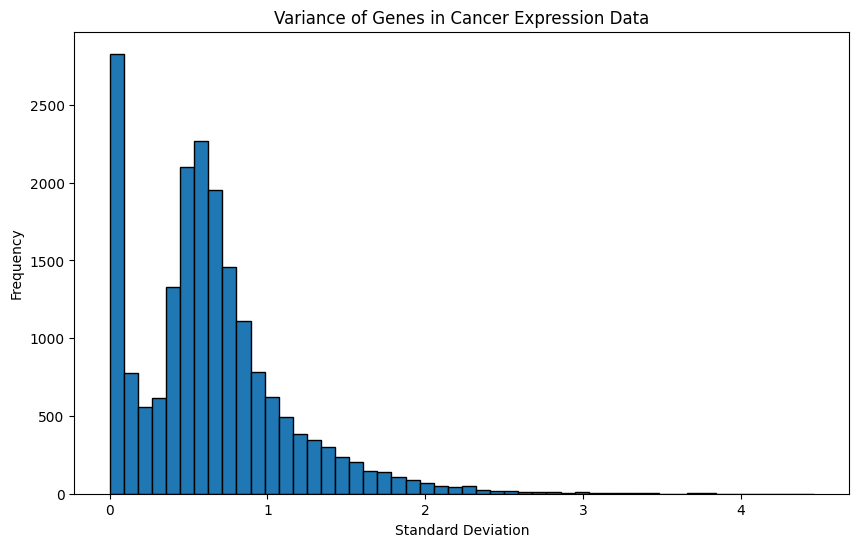

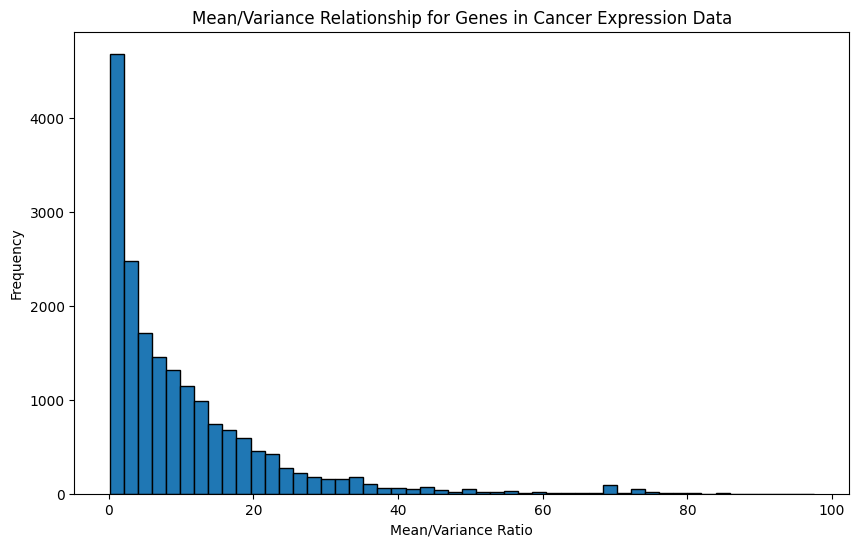

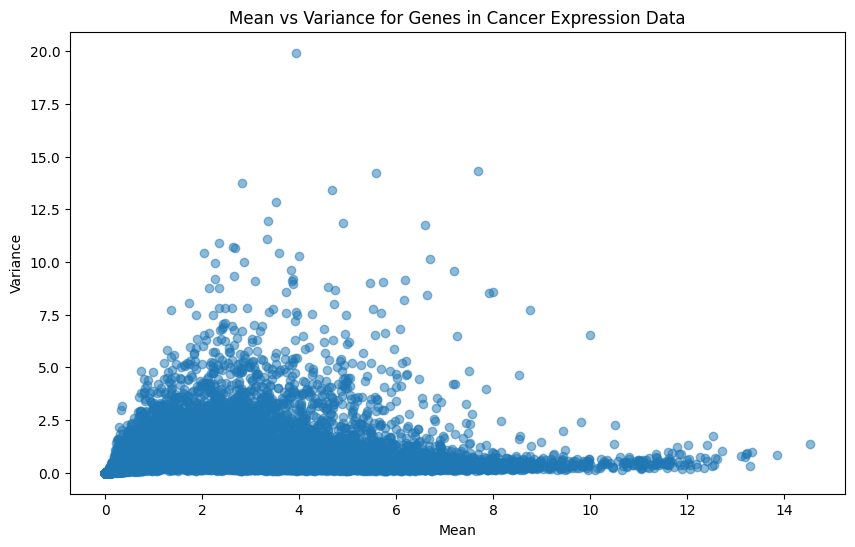

In [65]:
# make plot of variances of the genes
plt.figure(figsize=(10, 6))
plt.hist(cancer_expression.std(), bins=50, edgecolor='black')
plt.title('Variance of Genes in Cancer Expression Data')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.show()

# make second plot with mean-variance relationships for the genes

# Calculate mean and variance for each gene
mean_values = cancer_expression.mean(axis=0)
variance_values = cancer_expression.var(axis=0)

# create histogram of mean/variance values
plt.figure(figsize=(10, 6))
plt.hist(mean_values/variance_values, bins=50, edgecolor='black')
plt.title('Mean/Variance Relationship for Genes in Cancer Expression Data')
plt.xlabel('Mean/Variance Ratio')
plt.ylabel('Frequency')

plt.show()


# scatter plot of mean vs variance
plt.figure(figsize=(10, 6))
plt.scatter(mean_values, variance_values, alpha=0.5)
plt.title('Mean vs Variance for Genes in Cancer Expression Data')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.show()

Genes with high variances are informative genes. Simply selecting genes based on the variance is a common approach but possibly not optimal (because of the mean-variance relationship). We want to select genes that have a high variance with respect to their mean, to ensure that we capture highly variable genes while maintaining biological context.
Therefore, I will filter the expression data by setting a threshold on the CV = µ/

In [66]:
path = BASE_PATH + 'Depmap/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv'
ccle_expression = pd.read_csv(path, header=0, index_col=0)
ccle_expression.columns = [i.split(' ')[0] for i in ccle_expression.columns]

feature_dfs = {}
# Find intersection of cells
valid_expression_cells = set(cells) & set(ccle_expression.index)
#cells_with_features &= valid_expression_cells

if len(valid_expression_cells) == 0:
    print("Warning: No cells have expression data")
else:
    # Filter cells that are in our network
    cancer_expression = ccle_expression.loc[list(valid_expression_cells)]

print(cancer_expression.shape)


(30, 19138)


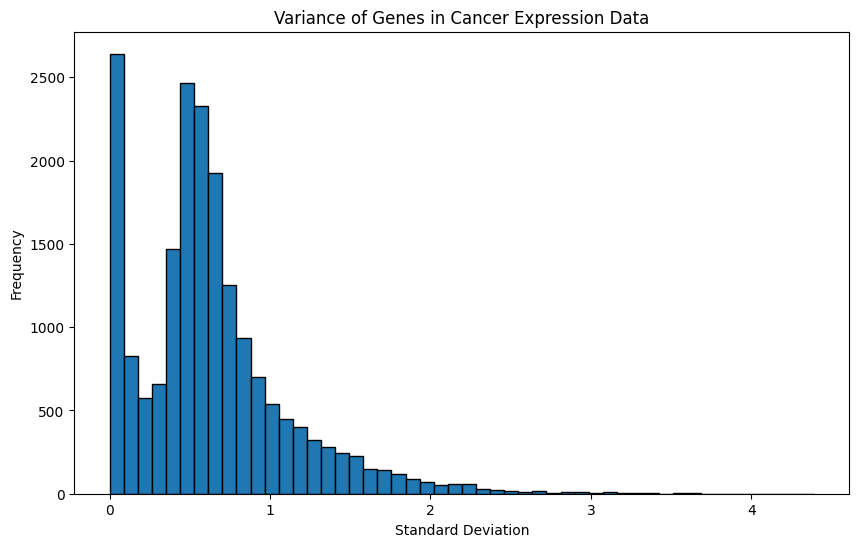

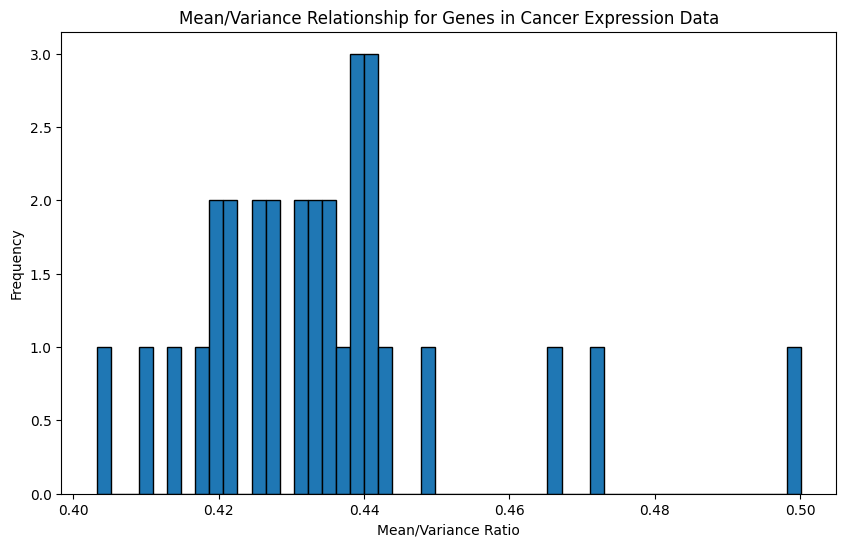

In [67]:
# make plot of variances of the genes
plt.figure(figsize=(10, 6))
plt.hist(cancer_expression.std(), bins=50, edgecolor='black')
plt.title('Variance of Genes in Cancer Expression Data')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')

plt.show()

# make second plot with mean-variance relationships for the genes

# Calculate mean and variance for each gene
mean_values = cancer_expression.mean(axis=1)
variance_values = cancer_expression.var(axis=1)

# create histogram of mean/variance values
plt.figure(figsize=(10, 6))
plt.hist(mean_values/variance_values, bins=50, edgecolor='black')
plt.title('Mean/Variance Relationship for Genes in Cancer Expression Data')
plt.xlabel('Mean/Variance Ratio')
plt.ylabel('Frequency')

plt.show()


In [68]:
path = BASE_PATH + 'Depmap/OmicsExpressionProteinCodingGenesTPMLogp1.csv'
ccle_expression = pd.read_csv(path, header=0, index_col=0)
ccle_expression.columns = [i.split(' ')[0] for i in ccle_expression.columns]

feature_dfs = {}
# Find intersection of cells
valid_expression_cells = set(cells) & set(ccle_expression.index)
#cells_with_features &= valid_expression_cells

if len(valid_expression_cells) == 0:
    print("Warning: No cells have expression data")
else:
    # Filter cells that are in our network
    cancer_expression = ccle_expression.loc[list(valid_expression_cells)]

    #Select columns with standard deviation > 0.2
    cancer_expression= cancer_expression.loc[:, cancer_expression.std() > 0.25]

print(cancer_expression.shape)


# make plot of variances of the genes


(29, 15142)


In [69]:
# Extract gene names from FEATURE column by removing "_Exr" suffix
marker_genes = expr_marker_genes['FEATURE'].str.replace('_Expr', '')

# Print the first few gene names to verify
print("First few marker genes:")
print(marker_genes.head())
print(marker_genes.shape)

valid_marker_genes = marker_genes[marker_genes.isin(cancer_expression.columns)]
unique_valid_marker_genes = valid_marker_genes.unique()
cancer_expression_features = cancer_expression[unique_valid_marker_genes]

# Print the shape and the first few columns of the filtered dataframe
print(f"\nShape of filtered cancer_expression: {cancer_expression_features.shape}")
print("\nFirst few columns of filtered dataframe:")
print(cancer_expression_features.head())

First few marker genes:
2       CISH
3    LAPTM4B
4       HBA1
5    FAM178B
6       NFE2
Name: FEATURE, dtype: object
(17271,)

Shape of filtered cancer_expression: (29, 2643)

First few columns of filtered dataframe:
                CISH   LAPTM4B      HBA1     ATP7B     KCNH2    MIPOL1  \
ACH-000804  2.883621  7.812434  0.000000  3.082362  7.170726  0.799087   
ACH-000078  2.639232  6.385258  0.000000  3.207893  6.037163  0.137504   
ACH-001548  1.505891  7.389481  0.411426  1.773996  4.471838  0.042644   
ACH-001354  1.469886  6.403609  1.021480  1.879706  4.864929  1.851999   
ACH-000366  2.063503  7.371210  0.516015  2.709291  5.225738  0.443607   

                PIM1      HBA2       HBB      CD69  ...      LY6K       FST  \
ACH-000804  4.327687  0.137504  0.056584  0.000000  ...  0.084064  0.310340   
ACH-000078  5.926474  0.124328  0.000000  0.056584  ...  0.056584  0.042644   
ACH-001548  2.521051  0.124328  0.000000  0.014355  ...  0.214125  1.150560   
ACH-001354  5.213347 

## MOSA

Let's load the latent vectors

In [70]:
import pandas as pd

MOSA = pd.read_csv(BASE_PATH + "20250221_151226_latent_joint.csv.gz",index_col=0)
print(MOSA.head())

# load cell line data
cellines = pd.read_csv(BASE_PATH+"Depmap/Model.csv",index_col="SangerModelID")
print(cellines.head())

# Merge MOSA with cellines on the 'modelID' column
MOSA = MOSA.merge(cellines[["ModelID"]], left_index=True, right_index=True)

print(MOSA.head())
print(MOSA.shape)


# remove rows that contain NaN values
MOSA = MOSA.dropna()

print(MOSA.shape)






           Latent_1  Latent_2  Latent_3  Latent_4  Latent_5  Latent_6  \
SIDM00001   0.29107   0.50726   0.55069  -0.67829  -0.38324   0.44616   
SIDM00003   0.49801   0.49337   0.56076  -0.72065  -0.38961   0.27088   
SIDM00005   0.61689   0.52278   0.61900  -0.56048  -0.43358   0.10027   
SIDM00008   0.60011   0.35171   0.75384  -0.61231  -0.53181   0.53114   
SIDM00011   0.41130   0.59379   0.65330  -0.73208  -0.38334   0.30167   

           Latent_7  Latent_8  Latent_9  Latent_10  ...  Latent_206  \
SIDM00001  -0.36255   0.72870  -0.44060    0.29047  ...     0.44422   
SIDM00003  -0.21029   0.74365  -0.51165    0.11107  ...     0.43928   
SIDM00005  -0.35365   0.86528  -0.34524   -0.14458  ...     0.46476   
SIDM00008  -0.51492   0.76512  -0.45614   -0.14835  ...     0.54957   
SIDM00011  -0.40324   0.81440  -0.51478    0.09716  ...     0.47274   

           Latent_207  Latent_208  Latent_209  Latent_210  Latent_211  \
SIDM00001    -0.57395    -0.77878    -0.33366     0.60202    

In [71]:
# create dictionary of modelID and latent vectors

latent_features_dict = {}

# Identify the columns for latent features (Latent_1 to Latent_215)
latent_columns = [col for col in MOSA.columns if col.startswith('Latent_')]

for index, row in MOSA.iterrows():
# Get the ModelID and the corresponding latent features
    model_id = row['ModelID']
    latent_features = row[latent_columns].values

    # Store in the dictionary
    latent_features_dict[model_id] = latent_features


In [72]:
#print(latent_features_dict)
print(len(latent_features_dict))
print(len(latent_features_dict['ACH-000001']))


1099
215


In [73]:
 # Load latent features and celline metadata
mosa_features = pd.read_csv(BASE_PATH + "20250221_151226_latent_joint.csv.gz", index_col=0)
cellines = pd.read_csv(BASE_PATH + "Depmap/Model.csv")

# Create mapping from SangerModelID to ModelID
sanger_to_model = dict(zip(cellines['SangerModelID'], cellines['ModelID']))

# Create a new index for MOSA features using ModelID
mosa_features['ModelID'] = mosa_features.index.map(sanger_to_model)
mosa_features = mosa_features.dropna()  # Remove any rows where mapping failed

# Set ModelID as the new index
mosa_features = mosa_features.set_index('ModelID')

# Find intersection of cells with our input cells
valid_cells = list(set(mosa_features.index))

if len(valid_cells) == 0:
    raise ValueError("No cells have MOSA data")

features = mosa_features.loc[valid_cells]


In [74]:
features


,Latent_1,Latent_2,Latent_3,Latent_4,Latent_5,Latent_6,Latent_7,Latent_8,Latent_9,Latent_10,...,Latent_206,Latent_207,Latent_208,Latent_209,Latent_210,Latent_211,Latent_212,Latent_213,Latent_214,Latent_215
ModelID,,,,,,,,,,,,,,,,,,,,,
ACH-000206,0.44311,0.46830,0.63403,-0.83271,-0.51716,0.45758,-0.41321,0.85142,-0.50525,0.25975,...,0.49390,-0.60937,-0.88932,-0.29720,0.62608,0.33011,-0.20625,-0.58973,0.59831,-0.69542
ACH-001958,0.50604,0.54503,0.64073,-0.65493,-0.30177,0.28984,-0.34196,0.80278,-0.41063,0.12237,...,0.29612,-0.40556,-0.85898,-0.22948,0.52958,0.45411,-0.48247,-0.45215,0.54407,-0.47641
ACH-000401,0.52197,0.39298,0.49144,-0.77090,-0.43222,0.42471,-0.43761,0.85417,-0.55457,-0.06616,...,0.61019,-0.40259,-0.66061,-0.18542,0.62842,0.40103,-0.46139,-0.53484,0.37148,-0.53051
ACH-000422,0.59567,0.53462,0.36527,-0.58742,-0.47942,0.37763,-0.25681,0.78209,-0.55378,0.23574,...,0.25968,-0.61283,-0.76937,-0.16479,0.65124,0.52925,-0.27048,-0.55464,0.41741,-0.52394
ACH-002271,0.52307,0.52815,0.52471,-0.66485,-0.38414,0.38446,-0.37822,0.76891,-0.52541,-0.00874,...,0.37379,-0.58947,-0.80034,-0.28326,0.58797,0.37590,-0.41603,-0.35258,0.63566,-0.52272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002146,0.44845,0.30901,0.44843,-0.74047,-0.35065,0.26371,-0.51096,0.72888,-0.36914,-0.03578,...,0.36911,-0.64267,-0.93075,-0.17104,0.50808,0.41877,-0.46383,-0.31809,0.57544,-0.61235
ACH-001528,0.37469,0.51315,0.71386,-0.44962,-0.42364,0.38853,-0.28506,0.99023,-0.41945,0.09967,...,0.41934,-0.40504,-0.89841,-0.28570,0.52945,0.12924,-0.17408,-0.48319,0.41766,-0.62429
ACH-000115,0.82008,0.62449,0.58203,-0.60622,-0.44404,0.29017,-0.34513,0.55428,-0.34782,-0.00032,...,0.30726,-0.51362,-0.99691,-0.35416,0.56068,0.52261,-0.47320,-0.45562,0.59206,-0.54437


In [75]:
# load heterodata object

path = BASE_PATH + '/multigraphs/heteroData_gene_cell_Neuroblastoma_cgp_MOSA.pt'
heteroData = torch.load(path)

heteroData 



HeteroData(
  gene={
    node_id=[13398],
    names=[13398],
    x=[13398, 3438],
  },
  cell={
    node_id=[25],
    names=[25],
    x=[25, 215],
  },
  (gene, interacts_with, gene)={ edge_index=[2, 263122] },
  (gene, dependency_of, cell)={ edge_index=[2, 2523] },
  (gene, rev_interacts_with, gene)={ edge_index=[2, 263122] },
  (cell, rev_dependency_of, gene)={ edge_index=[2, 2523] }
)